# Mapas

Este notebook es una adaptación del tutorial de Jake VanderPlas sobre Altair al que se han añadido otras fuentes.

In [1]:
import altair as alt
alt.renderers.enable('notebook')

import pandas as pd

## Gráficos de dispersión con coordenadas geográficas

Para empezar, mostraremos un ejemplo de graficar unos datos con longitud y latitud usando una proyección geográfica. 

Para ello usaremos un dataset con los aeropuertos estadounidenses.

In [2]:
from vega_datasets import data
airports = data.airports()
airports.head()

,iata,name,city,state,country,latitude,longitude
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


El gráfico es muy similar a un gráfico de dispersión, con unas pequeñas diferencias:

- especificamos la "latitude" y la "longitude" en vez de x e y
- especificamos una proyección 

En el caso de Estados Unidos, la proyección más común es la "albersUsa":

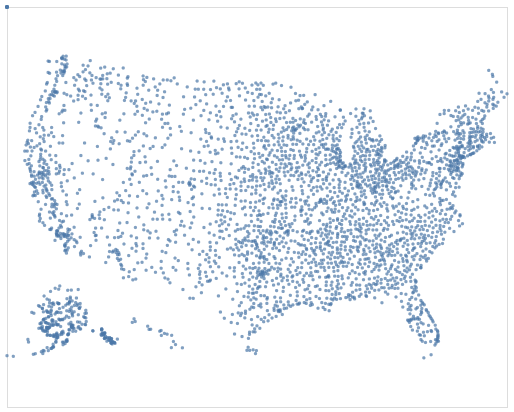

In [3]:
alt.Chart(airports).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.value(10),
    tooltip='name'
).project(
    "albersUsa"
).properties(
    width=500,
    height=400
)

Podéis consultar otras proyecciones en [vega documentation](https://vega.github.io/vega/docs/projections/).

## Mapas vectoriales

Si se quieren mostrar los límites geográficos, tales como estados o países, se debe cargar el dataset con los "polígonos" cartográficos y usar la marca``geoshape``.

Por ejemplo, el siguiente mapa muestra los límites de los estados:

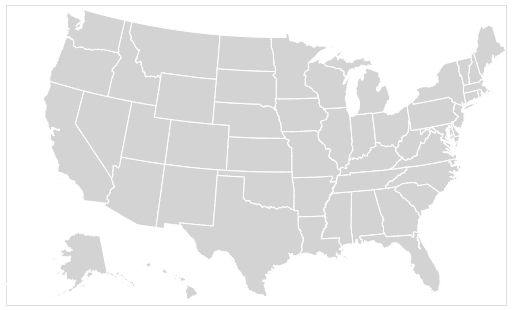

In [4]:
states = alt.topo_feature(data.us_10m.url, feature='states')

alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('albersUsa').properties(
    width=500,
    height=300
)

I aquí los límites de los países:

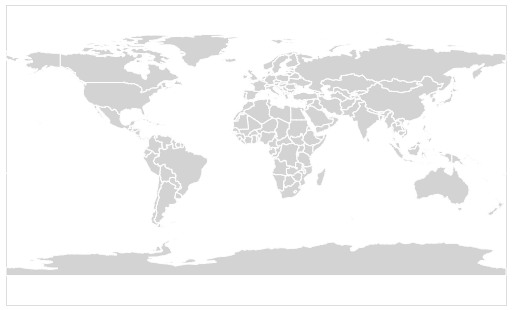

In [5]:
import altair as alt
from vega_datasets import data

countries = alt.topo_feature(data.world_110m.url, 'countries')

alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project(
    "equirectangular"
).properties(
    width=500,
    height=300
)

Podéis probar con otras proyecciones como por ejemplo "mercator", "orthographic", "albers", o "gnomonic".

Por defecto Altair ajusta la proyección para que el mapa quepa en el área indicada, pero se puede indicar una escala (nivel de zoom) y traslación (panning) para customizar la visualización del mapa.

Por ejemplo a continuación se customizan estos parámetros para focalizar el mapa en Europa:

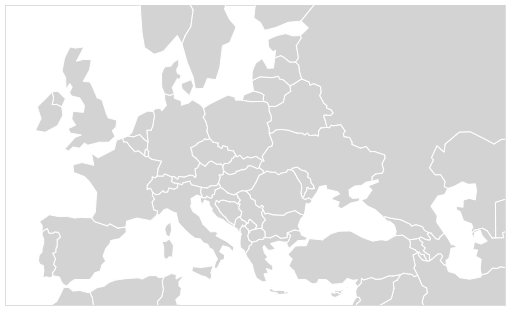

In [6]:
countries = alt.topo_feature(data.world_110m.url, 'countries')

alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project(
    type='mercator', scale=400, translate=[100, 550]
).properties(
    width=500,
    height=300
)

<h3 style="border-left:6px solid silver;background-color:#eeeeee;padding-left:10px"> Ejercicio 1</h3>

Probar de dibujar el mapa con un fondo marron y centrado en España. Para ver la escala y el centro necesario jugar con (las proyecciones interactivas en Vega)[https://vega.github.io/vega/docs/projections/] 

Fijaros que esta vez tendréis que codificar "center=[...,...]"

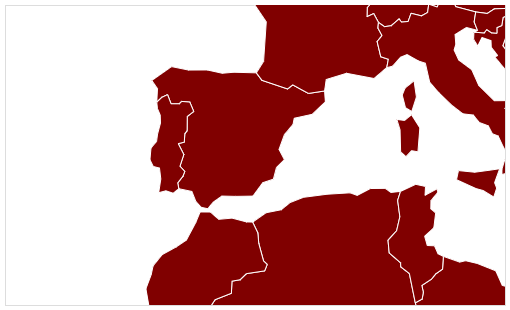

In [7]:
countries = alt.topo_feature(data.world_110m.url, 'countries')

alt.Chart(countries).mark_geoshape(
    fill='maroon',
    stroke='white'
).project(
    type='mercator', scale=800, center=[-2, 39]
).properties(
    width=500,
    height=300
)

## Mapa de símbolos

La manera más fácil de graficar un mapa de símbolos es con dos capas: una para el mapa con sus límites, y otra con los puntos.

Por ejemplo:

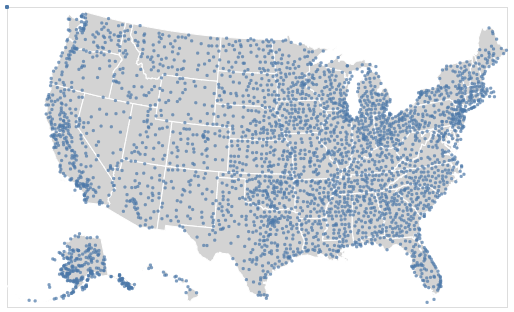

In [8]:
states = alt.topo_feature(data.us_10m.url, feature='states')
airports = data.airports()

background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('albersUsa').properties(
    width=500,
    height=300
)

points = alt.Chart(airports).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.value(10),
    tooltip='name'
)

background + points

Sólo hay que especificar la proyección y el tamaño del gráfico una vez.

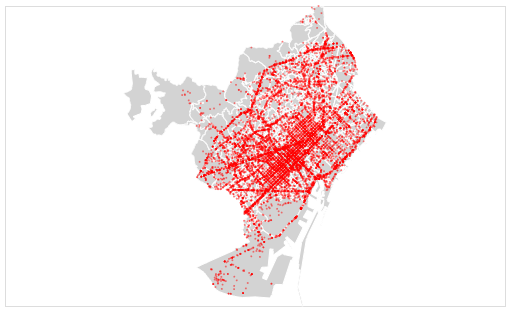

In [9]:
# Veamos un ejemplo con nuestros datos

municipios = alt.topo_feature("bcn.json", 'bcn')

basemap = alt.Chart(municipios).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=500,
    height=300
).project(
    type='mercator'
)

accidentes=alt.Chart('accidents_2017.csv').mark_circle(fill='#ff0000',opacity=0.5).encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    size=alt.value(3),
    tooltip='Serious injuries:N'
)

basemap + accidentes

In [10]:
# También los mapas se pueden guardar como HTML

(basemap + accidentes).save('mapabcn.html')

<h3 style="border-left:6px solid silver;background-color:#eeeeee;padding-left:10px"> Ejercicio 2</h3>

Crear un mapa similar para los datos de los accidentes de Barcelona en 2018, y mostrando por ejemplo el número de víctimas.

Anotación: al preparar este ejercicio hemos observado que algunas latitudes y longitudes no estaban bien codificadas en el fichero original, y hemos creado un nuevo fichero 2018_accidentes_limpio_latlongarreglada.csv con estos datos corregidos. Este es el que debeis usar para el ejercicio.


## Mapas de coropletas  (choropleth maps)

En los mapas de coropletas las regiones del mapa se colorean para reflejar los datos subyacentes.

Como ejemplo, a continuación el mapa representa la población total de cada estado:

In [11]:
population = data.population_engineers_hurricanes()
population.head()

,state,id,population,engineers,hurricanes
0,Alabama,1,4863300,0.003422,22
1,Alaska,2,741894,0.001591,0
2,Arizona,4,6931071,0.004774,0
3,Arkansas,5,2988248,0.002440,0
4,California,6,39250017,0.007126,0


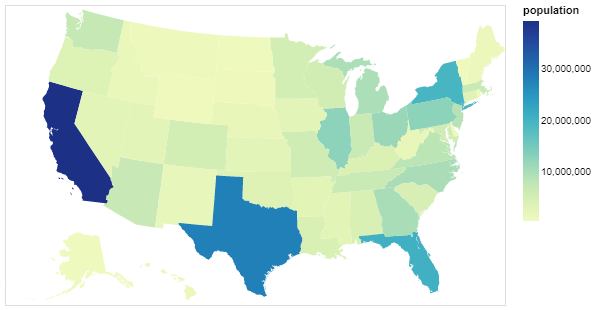

In [12]:
# Debemos relacionar los datos con el mapa
# y lo hacemos con transform_lookup. 
# cada estado en el mapa tiene una columna "id" 
# que se corresponde con la columna id
# del dataset de población;
# usamos esta columna como clave para hacer un join

import altair as alt
from vega_datasets import data

states = alt.topo_feature(data.us_10m.url, 'states')

alt.Chart(states).mark_geoshape().encode(
    color='population:Q'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(population, 'id', fields=['population', 'engineers', 'hurricanes'])
).properties(
    width=500,
    height=300
).project(
    type='albersUsa'
)

Los mapas en Altair tienen diversas ventajas, se pueden visualizar fácilmente en HTML, son interactivos... pero solo trabajan con mapas de polígonos.

Si queremos mapas con más información y "tiles" podemos usar la librería folium.

In [13]:
#  Para instalar FOLIUM
#  conda install -c conda-forge folium
#  podéis consultar también la chuleta en github

import folium

# Definir un mapa centrado en Barcelona
barcelona_map = folium.Map(location=[41.38879, 2.15899])

# Mostrar el mapa
barcelona_map

Y añadirle tambien capas de datos.

In [14]:
df = pd.read_csv('accidents_2017.csv')
df.rename(columns=lambda x:x.replace(' ','_').lower(), inplace=True)

# Mostrar los accidentes clasificados con heridas serias
for lat, lng, label in zip(df.latitude, df.longitude, df.serious_injuries.astype(str)):
    if label!='0':
        folium.Circle(
            [lat, lng],
            radius=0.2,
            color='red',
            fill=True,
            popup=label,
            fill_color='darkred',
            fill_opacity=0.6
        ).add_to(barcelona_map)
    
# Mostrar el mapa
barcelona_map